Absolute bias: -353.43967609015317
Percentage bias: -0.23562645072676877
Pull Mean:  -4.31 +/- 0.04
Pull Width: 1.20 +/- 0.03
True coverage of 68.3% error: 0.001 (but because biased)
Coverage even it were unbiased: 0.578 +/- 0.016 (6.7 sigma off)


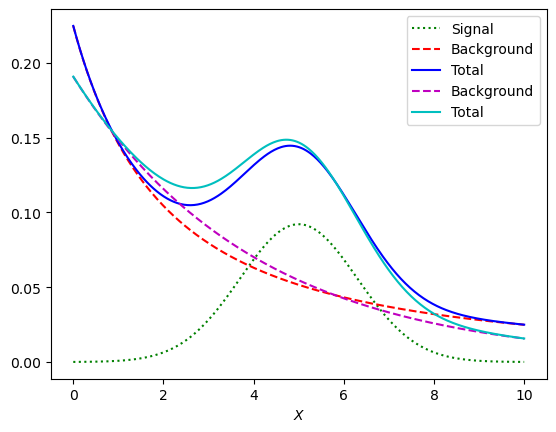

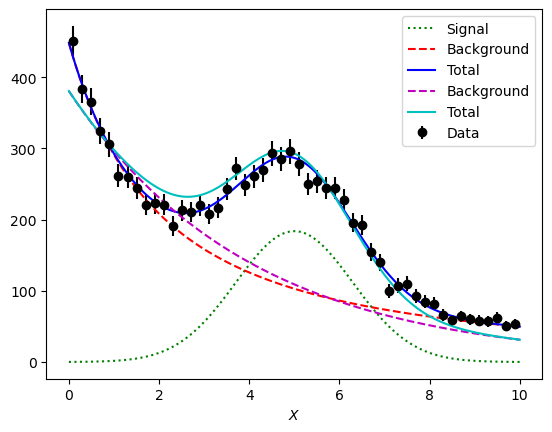

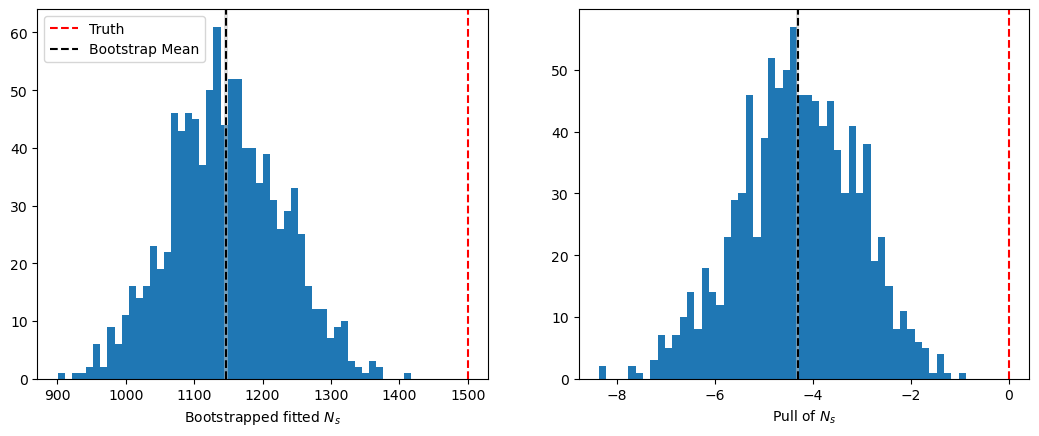

In [3]:
import numpy as np
np.random.seed(210187)
import matplotlib.pyplot as plt

from scipy.stats import norm, expon, pareto, truncnorm, truncexpon, truncpareto, chi2
from iminuit import cost, Minuit

from tqdm import tqdm

xrange = (0, 10)
x = np.linspace(*xrange, 400)

# true parameters
truth = { 'mu': 5,
          'sg': 1.3,
          'ba': 0.5,
          'bb': 3,
          'lb': 4,
          'f' : 0.3 }

def bmod_pl(a, b):
    c = (xrange[1]-xrange[0]+b)/b
    return truncpareto(b=a, c=c, loc=xrange[0]-b, scale=b)

def bmod_ex(lb):
    a = xrange[0]
    b = (xrange[1]-xrange[0])/lb
    return truncexpon(b=b, loc=a, scale=lb)

def smod(mu, sg):
    a, b = (xrange[0]-mu)/sg, (xrange[1]-mu)/sg
    return truncnorm(a=a, b=b, loc=mu, scale=sg)

def bpdf_pl(x, a, b):
    return bmod_pl(a, b).pdf(x) 

def bpdf_ex(x, lb):
    return bmod_ex(lb).pdf(x) 

def spdf(x, mu, sg):
    return smod(mu, sg).pdf(x)

def tpdf(x, Ns, Nb, mu, sg, lb):
    return Ns*spdf(x,mu,sg) + Nb*bpdf_ex(x,lb)

def tdens(x, Ns, Nb, mu, sg, lb):
    return Ns+Nb, tpdf(x, Ns, Nb, mu, sg, lb)

# generate function (use pl background)
def generate( size, pars=truth, poiss=True ):
    Ns = int(pars['f']*size)
    Nb = size - Ns
    
    if poiss:
        Ns = np.random.poisson(Ns)
        Nb = np.random.poisson(Nb)

    sm = smod(pars['mu'], pars['sg'])
    bm = bmod_pl(pars['ba'], pars['bb'])

    sv = sm.rvs(size=Ns)
    bv = bm.rvs(size=Nb)

    return np.concatenate( [sv,bv] )

# fit function (use ex background)
def fit( dset ):

    n2ll = cost.ExtendedUnbinnedNLL( dset, tdens )
    N = len(dset)
    mi = Minuit( n2ll, Ns=N*truth['f'], Nb=N*(1-truth['f']), mu=truth['mu'], sg=truth['sg'], lb=truth['lb'] )
    mi.migrad()
    mi.hesse()
    return mi

# plot function
def plot( dset=None, pars=truth, save=None):

    fig, ax = plt.subplots()
    
    N = 1
    bw = 1
    f = pars['f']

    if dset is not None:
        nh, xe = np.histogram( dset, bins=50, range=xrange )
        cx = 0.5*(xe[1:]+xe[:-1])
        bw = xe[1]-xe[0]
        N = len(dset)
        ax.errorbar( cx, nh, nh**0.5, fmt='ko', label='Data' )

    sy = N*bw*f*spdf(x, pars['mu'], pars['sg'])
    ax.plot(x, sy, 'g:', label='Signal' )

    if 'ba' in pars.keys() and 'bb' in pars.keys():
        by = N*bw*(1-f)*bpdf_pl(x, pars['ba'], pars['bb'])
        ax.plot(x, by, 'r--', label='Background')
        ax.plot(x, sy+by, 'b-', label='Total')

    if 'lb' in pars.keys():
        by = N*bw*(1-f)*bpdf_ex(x, pars['lb'])
        ax.plot(x, by, 'm--', label='Background')
        ax.plot(x, sy+by, 'c-', label='Total')


    ax.legend()
    ax.set_xlabel('$X$')

    if save is not None:
        fig.savefig(save)

# quick plot of the pdfs
plot()

# generate a sample to check
dset = generate(size=10000)
plot(dset, save='bias_coverage_toy.pdf')

# now run a few hundred toys
load = True 
nevs = 5000

if not load:
    ntoys = 1000

    # track fitted values and errors of toys
    fit_values = []
    fit_errors = []

    for i in tqdm(range(ntoys)):

        toy = generate(size=nevs)
        mi = fit(toy)
        fit_values.append( list(mi.values) )
        fit_errors.append( list(mi.errors) )
    
    parnames = mi.parameters
    fit_values = np.asarray( fit_values )
    fit_errors = np.asarray( fit_errors )

    np.savez( 'bias_coverage_toys.npz', pars=parnames, vals=fit_values, errs=fit_errors )

else:

    f = np.load( 'bias_coverage_toys.npz' )
    parnames = f.get('pars')
    fit_values = f.get('vals')
    fit_errors = f.get('errs')

# now check the bias, coverage, pull etc.

# only care about Ns so investigate this one only
arg = np.argwhere( parnames=='Ns' )
true = truth['f']*nevs
vals = fit_values[:,arg].flatten()
errs = fit_errors[:,arg].flatten()
pull = (vals-true)/errs

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax[0].hist( vals, bins=50 )
ax[0].axvline( true, c='r', ls='--', label='Truth' )
mu_val = np.mean( vals )
mu_err = np.std( vals, ddof=1 )/ len(vals)**0.5
ax[0].axvspan( mu_val-mu_err, mu_val+mu_err, fc='0.75', alpha=0.5 )
ax[0].axvline( mu_val, c='k', ls='--', label='Bootstrap Mean' )
ax[0].set_xlabel('Bootstrapped fitted $N_s$')
ax[0].legend()

bias = (mu_val - true)
bias_perc = bias / true

print('Absolute bias:', bias)
print('Percentage bias:', bias_perc)

ax[1].hist( pull, bins=50 )
ax[1].axvline( 0, c='r', ls='--' )
mu_val = np.mean( pull )
sg_val = np.std( pull, ddof=1)
mu_err = sg_val/len(vals)**0.5
sg_err = sg_val/(2*len(vals)-1)**0.5
ax[1].axvspan( mu_val-mu_err, mu_val+mu_err, fc='0.75', alpha=0.5)
ax[1].axvline( mu_val, c='k', ls='--')
ax[1].set_xlabel('Pull of $N_s$')

print(f'Pull Mean:  {mu_val:4.2f} +/- {mu_err:4.2f}')
print(f'Pull Width: {sg_val:4.2f} +/- {sg_err:4.2f}')

cov = np.sum( np.abs((vals-true)/errs) < 1 ) / len(vals)
print( 'True coverage of 68.3% error:', cov, '(but because biased)' )

# compute cov if we weren't biased
k = np.sum( np.abs((pull-mu_val)) < 1 )
N = len(pull)
off_cov = k/N
off_cov_err = (1/N)*np.sqrt( k*(1-k/N) )
sigma_from_correct = np.abs( off_cov - chi2.cdf(1,1) ) / off_cov_err 
print( f'Coverage even it were unbiased: {off_cov:5.3f} +/- {off_cov_err:5.3f} ({sigma_from_correct:3.1f} sigma off)' )


fig.savefig('bias_coverage_summary.pdf')
plt.show()